# Distance basis, feature 2 (60 salt bridge distances)
Down to up transition

In [1]:
import numpy as np
import extq
import matplotlib.pyplot as plt
from matplotlib import ticker
import pyemma
import glob
import sys
import importlib
import gc
import sklearn
from sklearn import metrics
import ivac
import seaborn as sns

In [2]:
sys.path.insert(1, "../../python")
sys.path.insert(1, "../../..")
import util
import kde

In [3]:
plt.style.use("seaborn-ticks")
sns.set_palette("colorblind")

# Load feature 2 data (salt bridges)

In [4]:
with np.load("../../data/raw_feat/feat2_raw.npz", allow_pickle=True) as f:
    data = f["arr_0"]

In [5]:
print(len(data))
print(data[0].shape)

1295
(3000, 60)


In [6]:
data_arr = np.concatenate(data)
print(data_arr.shape)

(6580000, 60)


## load CVs 

In [7]:
with np.load("../../data/raw_feat/cv_dist_spin.npz", allow_pickle=True) as f:
    cv_arr = f["arr_0"]

In [8]:
traj_lens = [len(traj) for traj in data]
traj_inds = []
subtot = 0
for length in traj_lens[:-1]:
    subtot += length
    traj_inds.append(subtot)
cv_trajs = np.split(cv_arr, traj_inds)

In [9]:
cv_arr.shape

(6580000, 2)

In [10]:
livac_trajs = np.load("../../data/sb_ind100_TICA/livac_trajs.npy", allow_pickle=True)
livac_arr = np.concatenate(livac_trajs)
models_km100 = np.load("../../data/sb_ind100_TICA/models.npy", allow_pickle=True)

In [11]:
with np.load("../../data/raw_feat/ri126_dist.npz", allow_pickle=True) as f:
    ri_trajs = f["arr_0"]
ri_arr = np.concatenate(ri_trajs)
ri_arr.shape

(6580000, 5)

In [12]:
sb_labels = []
for r in ("R217", "R223", "R226", "R229", "R232"):
    for n in ("D129", "D136", "D151", "D164", "E183", "D186"):
        sb_labels.append(f"{r} - {n}")

In [13]:
# useful salt bridges
# R223-D129, R226-D129, R229-D129, R226-D186, R229-D186, R232-D186
sb_ids = [36, 42, 48, 47, 53, 59]

In [14]:
cv_arr = np.hstack((cv_arr, data_arr[:, sb_ids], ri_arr, livac_arr))

In [15]:
cv_arr.shape

(6580000, 18)

In [16]:
cv_trajs = np.split(cv_arr, traj_inds)

In [17]:
names = [
    "Distance / $\AA$",
    "Rotation / $^\circ$",
    "R223-D129",
    "R226-D129",
    "R229-D129",
    "R226-D186",
    "R229-D186",
    "R232-D186",
    "R217-I126",
    "R223-I126",
    "R226-I126",
    "R229-I126",
    "R232-I126",
    "iTIC0",
    "iTIC1",
    "iTIC2",
    "iTIC3",
    "iTIC4",
]

# States 

In [18]:
dist = cv_arr[:, 0]
rot = cv_arr[:, 1]
tic1 = cv_arr[:, 14]
tic2 = cv_arr[:, 15]
sb5 = cv_arr[:, 5]  # R2-D186
sb6 = cv_arr[:, 6]  # R3-D186
sb7 = cv_arr[:, 7]  # R4-D186
sb3 = cv_arr[:, 3]  # R2-D129


# ellipse centered at (-4.174, -50.8) with radii 1.1 nm and 16 deg (2 sigma in each direction) for down state
# take points where TIC 1 < 1.2 and R2/R3-D186 distance < 0.5/0.55 (lower salt bridges)
dist_ax_down = (dist + 4.174) / 1.1
rot_ax_down = (rot + 50.8) / 16
down_ids = (
    ((dist_ax_down ** 2 + rot_ax_down ** 2) < 1)
    & (sb5 < 0.5)
    & (sb6 < 0.55)
    & (sb3 > 0.6)
    & (tic1 < 1.2)
).nonzero()[0]

# ellipse centered at (0, 0) with radii 0.84 nm and 7.6 deg (2 sigma in each direction) for down state
# take points where TIC 2 > -1.0 and R3/R4-D186 salt bridges < 0.5/0.6 nm, R2-D186 > 1
up_ids = (
    (((dist / 0.84) ** 2 + (rot / 7.6) ** 2) < 1)
    & (sb6 < 0.5)
    & (sb7 < 0.6)
    & (sb5 > 1.0)
    & (tic2 > -1)
).nonzero()[0]

In [19]:
mask = np.ones(len(cv_arr), dtype=bool)
mask[down_ids] = False
mask[up_ids] = False

# len(**_ids) is number of points in each state
down = data_arr[down_ids]
up = data_arr[up_ids]
other = data_arr[mask]

# split CV data
down_cvs = cv_arr[down_ids]
up_cvs = cv_arr[up_ids]
other_cvs = cv_arr[mask]

In [20]:
assert (len(down) + len(up) + len(other)) == len(cv_arr)
print(f"Number of down structures:  {len(down)}")
print(f"Number of up structures:   {len(up)}")
print(f"Number of other structures: {len(other)}")

Number of down structures:  36886
Number of up structures:   93105
Number of other structures: 6450009


## plot new states 

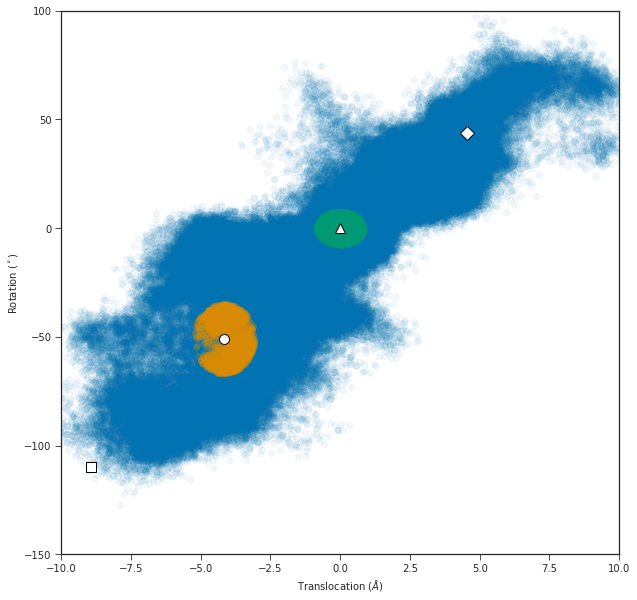

In [31]:
f, ax = plt.subplots(figsize=(10, 10))
ax.scatter(*other_cvs[::20, :2].T, alpha=0.05)
for cv_group in (down_cvs, up_cvs):
    ax.scatter(*cv_group[::20, :2].T, alpha=0.2)
util.format_cvs(ax)

# Pairwise distances

In [32]:
print(sklearn.get_config()["working_memory"])

1024


In [33]:
# compute minimum distance (minimum of column) from domain to dimeric/monomeric state
def reduce_func(D_chunk, start):
    min2 = np.min(D_chunk, axis=1)
    return min2

In [34]:
d_down = []
counter = 0.0
tot = len(data_arr)
skip = 3

for chunk in metrics.pairwise_distances_chunked(
    data_arr, down[::skip], n_jobs=-1, reduce_func=reduce_func
):
    d_down.append(chunk)
    counter += float(len(chunk))
    perc = counter / tot * 100
    print(f"{perc:.2f}% completed")

0.17% completed
0.33% completed
0.50% completed
0.66% completed
0.83% completed
1.00% completed
1.16% completed
1.33% completed
1.49% completed
1.66% completed
1.82% completed
1.99% completed
2.16% completed
2.32% completed
2.49% completed
2.65% completed
2.82% completed
2.99% completed
3.15% completed
3.32% completed
3.48% completed
3.65% completed
3.82% completed
3.98% completed
4.15% completed
4.31% completed
4.48% completed
4.64% completed
4.81% completed
4.98% completed
5.14% completed
5.31% completed
5.47% completed
5.64% completed
5.81% completed
5.97% completed
6.14% completed
6.30% completed
6.47% completed
6.64% completed
6.80% completed
6.97% completed
7.13% completed
7.30% completed
7.46% completed
7.63% completed
7.80% completed
7.96% completed
8.13% completed
8.29% completed
8.46% completed
8.63% completed
8.79% completed
8.96% completed
9.12% completed
9.29% completed
9.46% completed
9.62% completed
9.79% completed
9.95% completed
10.12% completed
10.28% completed
10.45%

In [35]:
print(len(d_down), d_down[0].shape)

# Set all distances of point in monomer state to be 0 explicitly
d_down_arr = np.reshape(np.concatenate(d_down), (-1, 1))
print(d_down_arr.shape)
print(np.max(d_down_arr[down_ids]))
d_down_arr[down_ids] = 0
print(np.max(d_down_arr[down_ids]))

print(d_down_arr.shape)

603 (10915,)
(6580000, 1)
1.3222582
0.0
(6580000, 1)


In [37]:
np.save("../../data/feat2_dist_du/dist_down", d_down_arr)

## Up+state

In [38]:
d_up = []
counter = 0.0
skip = 3

for chunk in metrics.pairwise_distances_chunked(
    data_arr, up[::skip], n_jobs=20, reduce_func=reduce_func
):
    d_up.append(chunk)
    counter += float(len(chunk))
    perc = counter / tot * 100
    print(f"{perc:.2f}% completed")

0.07% completed
0.13% completed
0.20% completed
0.26% completed
0.33% completed
0.39% completed
0.46% completed
0.53% completed
0.59% completed
0.66% completed
0.72% completed
0.79% completed
0.85% completed
0.92% completed
0.99% completed
1.05% completed
1.12% completed
1.18% completed
1.25% completed
1.31% completed
1.38% completed
1.45% completed
1.51% completed
1.58% completed
1.64% completed
1.71% completed
1.77% completed
1.84% completed
1.91% completed
1.97% completed
2.04% completed
2.10% completed
2.17% completed
2.23% completed
2.30% completed
2.37% completed
2.43% completed
2.50% completed
2.56% completed
2.63% completed
2.69% completed
2.76% completed
2.83% completed
2.89% completed
2.96% completed
3.02% completed
3.09% completed
3.15% completed
3.22% completed
3.29% completed
3.35% completed
3.42% completed
3.48% completed
3.55% completed
3.61% completed
3.68% completed
3.75% completed
3.81% completed
3.88% completed
3.94% completed
4.01% completed
4.07% completed
4.14% co

In [39]:
print(len(d_up), d_up[0].shape)

# Set all distances of point in monomer state to be 0 explicitly
d_up_arr = np.reshape(np.concatenate(d_up), (-1, 1))
print(d_up_arr.shape)
print(np.max(d_up_arr[up_ids]))
d_up_arr[up_ids] = 0
print(np.max(d_up_arr[up_ids]))

print(d_up_arr.shape)

1522 (4324,)
(6580000, 1)
0.97510415
0.0
(6580000, 1)


In [41]:
np.save("../../data/feat2_dist_du/dist_up", d_up_arr)

# Smoothing and guess functions 

In [44]:
# make smoothing function
smooth = (d_down_arr * d_up_arr) ** 0.5 / (d_down_arr + d_up_arr)

# make guess
guess_down = (d_up_arr / (d_down_arr + d_up_arr)) ** 2
guess_up = (d_down_arr / (d_down_arr + d_up_arr)) ** 2

# make smoothing 0 at boundaries (dimer and monomer states)
smooth[(mask == 0).flatten()] = 0
# ensure homogeneous boundary conditions for guess
guess_up[up_ids] = 1
guess_up[down_ids] = 0
guess_down[down_ids] = 1
guess_down[up_ids] = 0

In [46]:
print(smooth.shape, guess_down.shape, guess_up.shape)

(6580000, 1) (6580000, 1) (6580000, 1)


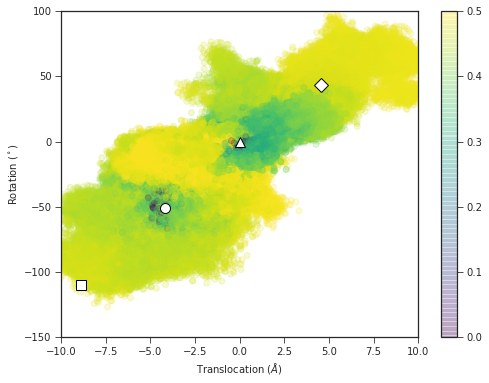

In [47]:
# Plot smoothing function
fig, ax = plt.subplots(figsize=(8, 6))
h = ax.scatter(
    cv_arr[::10, 0], cv_arr[::10, 1], c=smooth[::10], alpha=0.2, cmap="viridis"
)
cplt.colorbar(h, ax=ax)
util.format_cvs(ax)

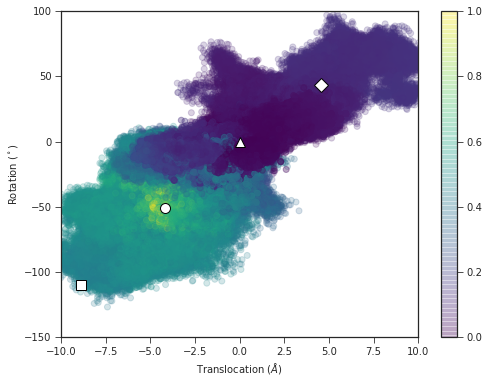

In [48]:
# Plot down state guess function
fig, ax = plt.subplots(figsize=(8, 6))
h = ax.scatter(
    cv_arr[::10, 0], cv_arr[::10, 1], c=guess_down[::10], alpha=0.2, cmap="viridis"
)
plt.colorbar(h, ax=ax)
util.format_cvs(ax)

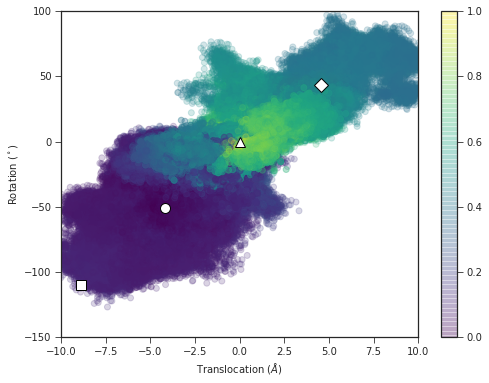

In [49]:
# Plot up state guess function
fig, ax = plt.subplots(figsize=(8, 6))
h = ax.scatter(
    cv_arr[::10, 0], cv_arr[::10, 1], c=guess_up[::10], alpha=0.2, cmap="viridis"
)
plt.colorbar(h, ax=ax)
util.format_cvs(ax)

## Construct bases

In [50]:
gc.collect()

12036

In [51]:
basis_smooth = smooth * data_arr
print(basis_smooth.shape)
basis_white, L = util.svd_whiten(basis_smooth, 1, frac_retain=1.0)
basis_white[(mask == 0).flatten()] = 0
print(basis_white.shape)

(6580000, 60)
(6580000, 59)


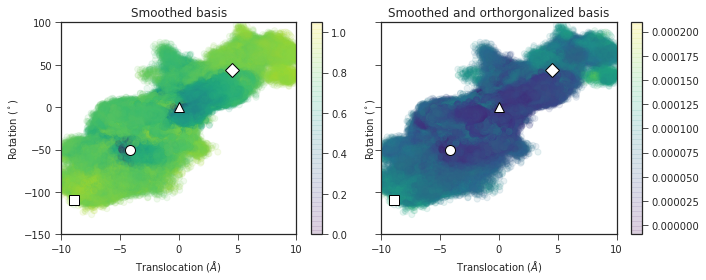

In [52]:
# plot bases
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
h1 = ax1.scatter(
    cv_arr[::10, 0],
    cv_arr[::10, 1],
    c=np.mean(basis_smooth[::10, :], axis=1),
    alpha=0.1,
    cmap="viridis",
)
h2 = ax2.scatter(
    cv_arr[::10, 0],
    cv_arr[::10, 1],
    c=np.mean(basis_white[::10, :], axis=1),
    alpha=0.1,
    cmap="viridis",
)
for ax in (ax1, ax2):
    util.format_cvs(ax)
ax1.set_title("Smoothed basis")
ax2.set_title("Smoothed and orthorgonalized basis")
plt.colorbar(h1, ax=ax1)
plt.colorbar(h2, ax=ax2)
f.tight_layout()

In [54]:
np.save("../../data/feat2_dist_du/basis_white_du.npy", basis_white)
np.save("../../data/feat2_dist_du/guess_down_du.npy", guess_down)
np.save("../../data/feat2_dist_du/guess_up_du.npy", guess_up)

## Convert to lists of np arrays 

In [56]:
# basis_white = basis_white[:, 1:]

# basisL = data_trajs
basisF = np.split(basis_white, traj_inds)
guessU = np.split(np.squeeze(guess_up), traj_inds)
guessD = np.split(np.squeeze(guess_down), traj_inds)

# print(len(basisL), basisL[0].shape)
print(len(basisF), basisF[0].shape)
print(len(guessU))
print(len(guessD))

1295 (3000, 59)
1295
1295


In [32]:
# unit is 0.1 ps, up to 100 ns
lags = [1, 2, 5, 10, 20, 30, 40, 50, 100, 200, 300, 400, 500, 1000, 2000]

## Load weights 

In [59]:
weights = np.load("../../data/coms_feat2.npy", allow_pickle=True)

# Committors 

In [60]:
in_domain = np.split(mask, traj_inds)
q_downup, qb_downup, q_updown, qb_updown = [], [], [], []
for (lag, com) in zip(lags, weights):
    print(f"Calculating committors for lag {lag}")
    q_downup.append(extq.dga.forward_committor(basisF, com, in_domain, guessU, lag))
    qb_downup.append(extq.dga.backward_committor(basisF, com, in_domain, guessD, lag))
    q_updown.append(extq.dga.forward_committor(basisF, com, in_domain, guessD, lag))
    qb_updown.append(extq.dga.backward_committor(basisF, com, in_domain, guessU, lag))

Calculating committors for lag 1
Calculating committors for lag 2
Calculating committors for lag 5
Calculating committors for lag 10
Calculating committors for lag 20
Calculating committors for lag 30
Calculating committors for lag 40
Calculating committors for lag 50
Calculating committors for lag 100
Calculating committors for lag 200
Calculating committors for lag 300
Calculating committors for lag 400
Calculating committors for lag 500
Calculating committors for lag 1000
Calculating committors for lag 2000


In [61]:
np.save("../../data/feat2_dist_du/q_du_feat2.npy", q_downup)
np.save("../../data/feat2_dist_du/qb_du_feat2.npy", qb_downup)
np.save("../../data/feat2_dist_du/q_ud_feat2.npy", q_updown)
np.save("../../data/feat2_dist_du/qb_ud_feat2.npy", qb_updown)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [110]:
q_downup = np.load("../../data/feat2_dist_du/q_du_feat2.npy", allow_pickle=True)
qb_downup = np.load("../../data/feat2_dist_du/qb_du_feat2.npy", allow_pickle=True)
q_updown = np.load("../../data/feat2_dist_du/q_ud_feat2.npy", allow_pickle=True)
qb_updown = np.load("../../data/feat2_dist_du/qb_ud_feat2.npy", allow_pickle=True)

## Down to up 

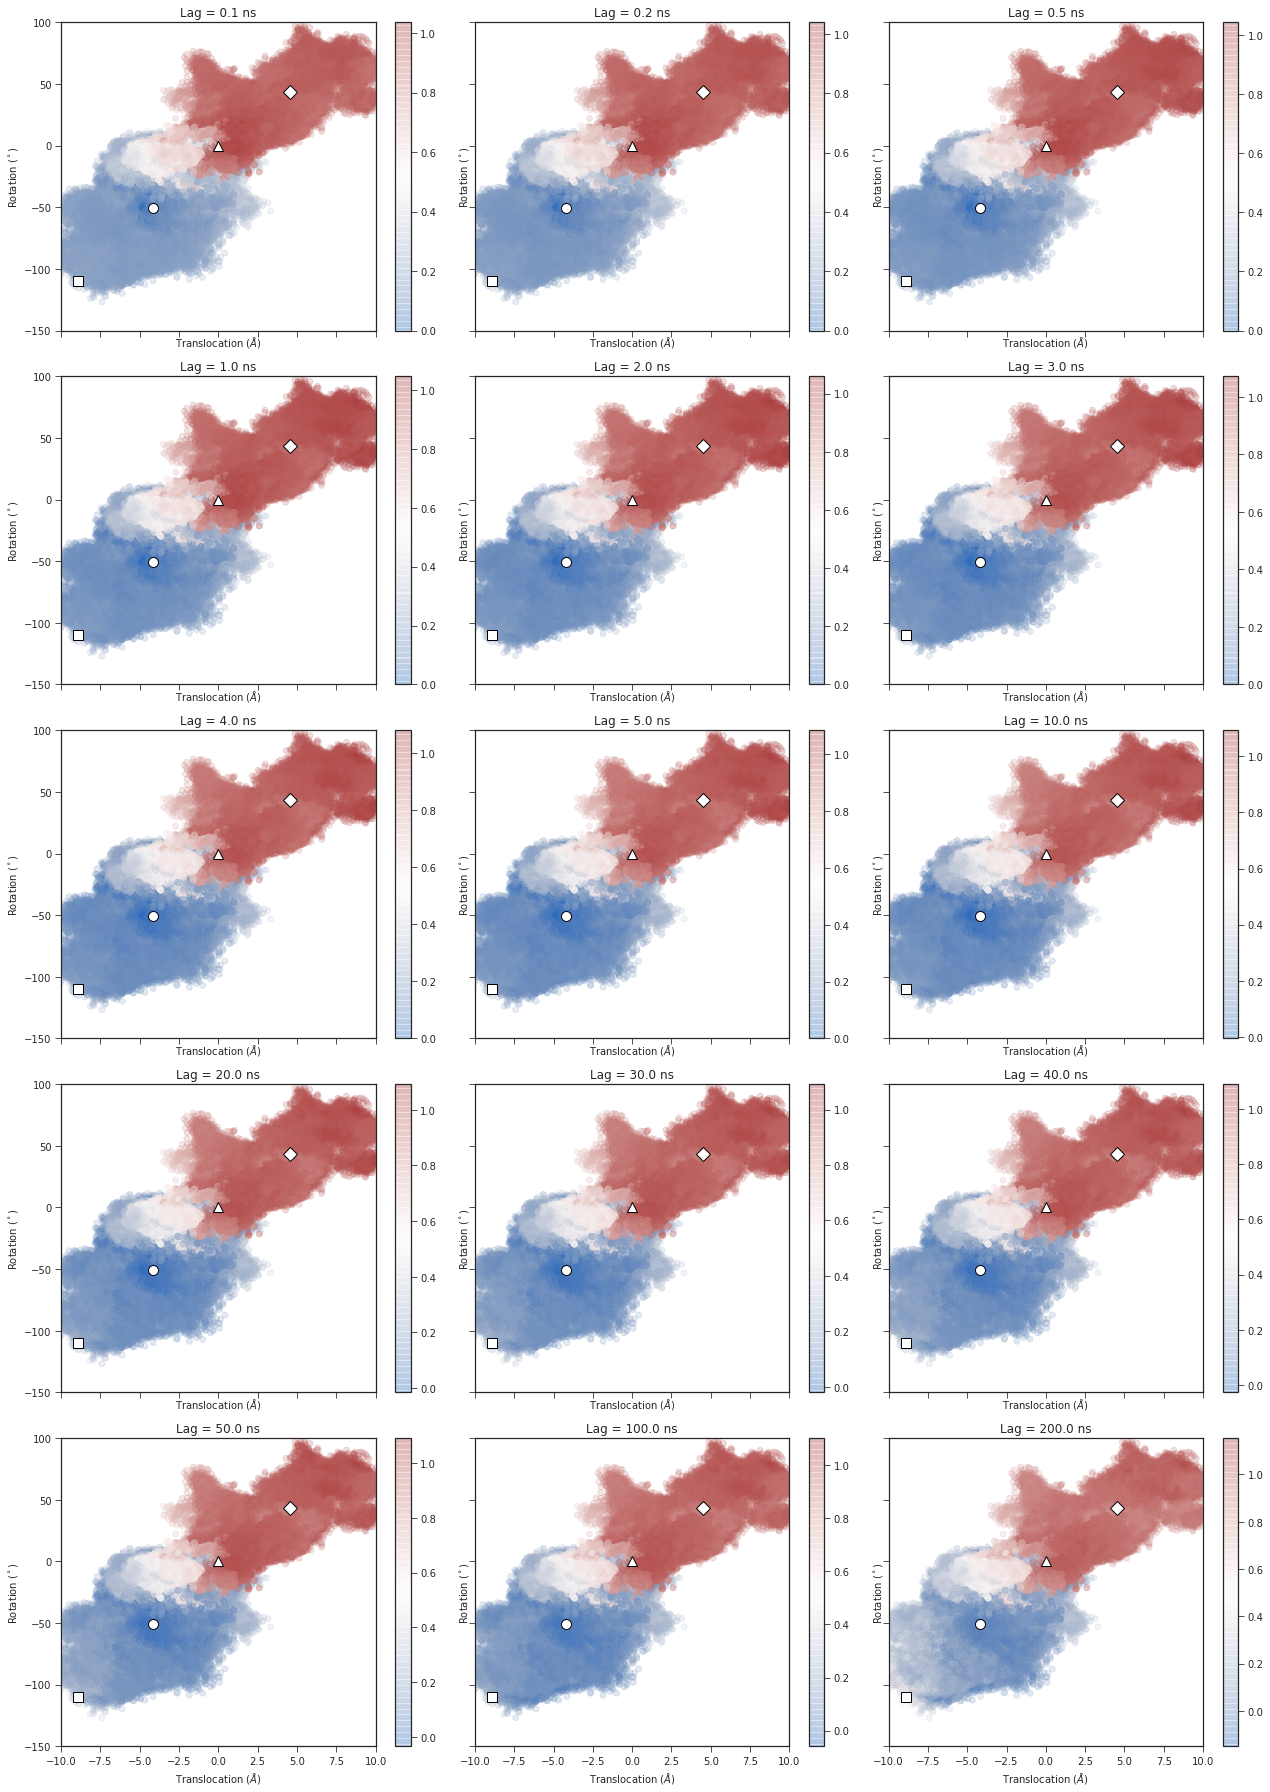

In [112]:
f, axs = plt.subplots(5, 3, figsize=(18, 25), sharex=True, sharey=True)
for lag, q, ax in zip(lags, q_downup, axs.flatten()):
    q_arr = np.concatenate(q)
    h = ax.scatter(
        cv_arr[::10, 0], cv_arr[::10, 1], c=q_arr[::10], cmap="vlag", alpha=0.2
    )
    plt.colorbar(h, ax=ax)
    ax.set_title(f"Lag = {lag * 0.1} ns")
    util.format_cvs(ax)

f.tight_layout()
plt.savefig("../../fig/committors/qf_du_feat2dist_activation_alllags_ds")

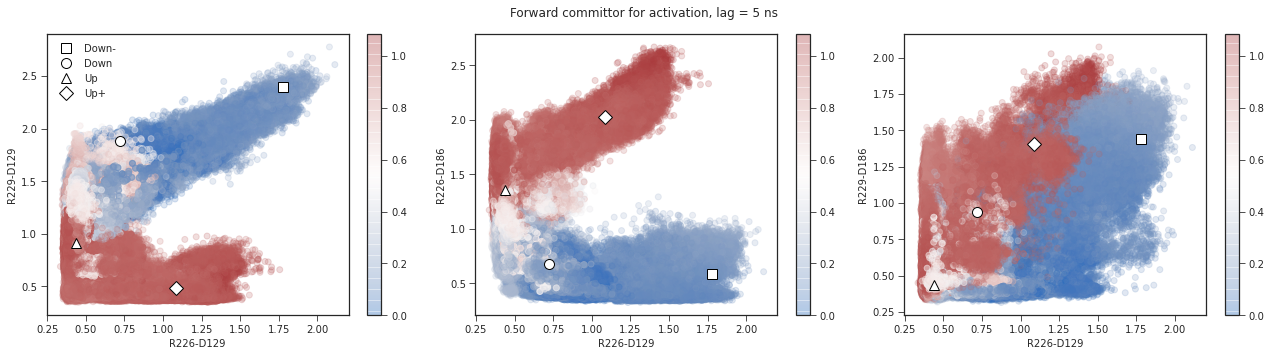

In [113]:
# projection on salt bridges
# R2-D129 vs R3-D129, R2-D186, R3-D186
f, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True)
q = np.concatenate(q_downup[7])
for i, ax in enumerate(axs):
    h = ax.scatter(
        cv_arr[::10, 3], cv_arr[::10, i + 4], c=q[::10], cmap="vlag", alpha=0.2
    )
    plt.colorbar(h, ax=ax)
    ax.set(xlabel=names[3], ylabel=names[i + 4])
util.plot_models(axs[0], feat2_models[:, 42:49:6])  # indexes 42 and 48
util.plot_models(axs[1], feat2_models[:, 42:48:5])  # 42 and 47
util.plot_models(axs[2], feat2_models[:, 42:54:11])  # 42 and 53
axs[0].legend(["Down-", "Down", "Up", "Up+"])
f.suptitle("Forward committor for activation, lag = 5 ns")
f.tight_layout()
plt.savefig("../../fig/committors/qf_du_feat2dist_activation_lag50_r2d129")

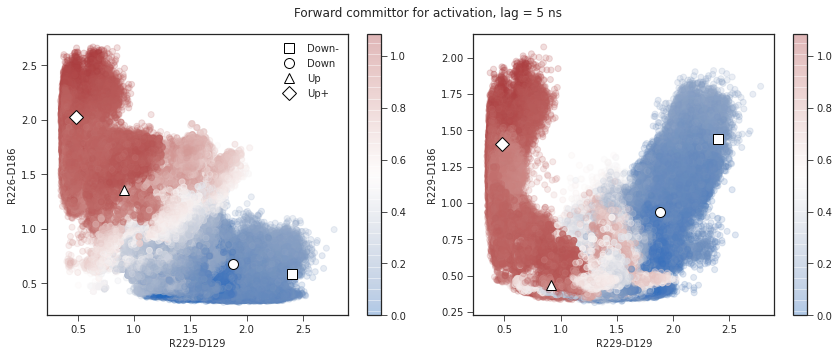

In [114]:
f, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
q = np.concatenate(q_downup[7])
for i, ax in enumerate(axs):
    h = ax.scatter(
        cv_arr[::10, 4], cv_arr[::10, i + 5], c=q[::10], cmap="vlag", alpha=0.2
    )
    plt.colorbar(h, ax=ax)
    ax.set(xlabel=names[4], ylabel=names[i + 5])
util.plot_models(axs[0], feat2_models[:, 48:46:-1])  # indexes 48 and 47
util.plot_models(axs[1], feat2_models[:, 48:54:5])  # 48 and 53
axs[0].legend(["Down-", "Down", "Up", "Up+"])
f.suptitle("Forward committor for activation, lag = 5 ns")
f.tight_layout()
plt.savefig("../../fig/committors/qf_du_feat2dist_activation_lag50_r3d129")

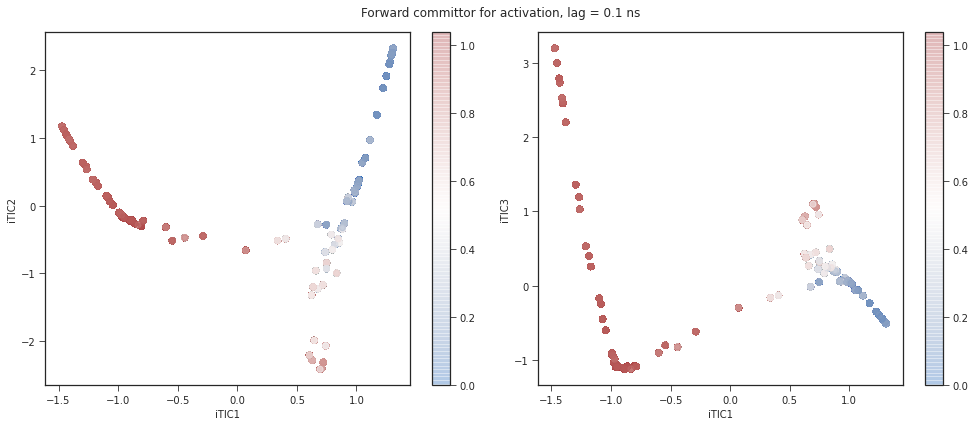

In [67]:
f, axs = plt.subplots(1, 2, figsize=(14, 6), sharex=True)
q = np.concatenate(q_downup[0])
for i, ax in enumerate(axs):
    h = ax.scatter(
        cv_arr[::10, 14], cv_arr[::10, i + 15], c=q[::10], cmap="vlag", alpha=0.2
    )
    plt.colorbar(h, ax=ax)
    ax.set(xlabel=names[14], ylabel=names[i + 15])
f.suptitle("Forward committor for activation, lag = 0.1 ns")
f.tight_layout()

# Feat1 indicator basis 

5.27.21

In [21]:
feat1_trajs = np.load("../../data/raw_feat/feat1_ivac_ind200.npy")

In [22]:
feat1_trajs.shape

(1, 6580000)

In [23]:
feat1_arr = feat1_trajs.squeeze()

In [24]:
feat1_arr.shape

(6580000,)

## Basis 

In [25]:
guess_down = np.zeros_like(feat1_arr)
guess_down[down_ids] = 1
guessD = np.split(guess_down, traj_inds)
guess_up = np.zeros_like(feat1_arr)
guess_up[up_ids] = 1
guessU = np.split(guess_up, traj_inds)

In [26]:
guess_down.shape

(6580000,)

In [27]:
# indicator basis
basisF_arr = np.zeros((len(cv_arr), 200))
for i in range(200):
    basisF_arr[feat1_arr == i, i] = 1

# enforce boundary conditions
basisF_arr[down_ids] = 0
basisF_arr[up_ids] = 0

In [28]:
assert basisF_arr[down_ids].all() == 0
assert basisF_arr[up_ids].all() == 0

In [29]:
# remove bases which are completely 0 (i.e. entirely contained in A U B)
nonzero = np.where(np.sum(basisF_arr, axis=0) > 0)[0]

basisF_arr = basisF_arr[:, nonzero]

In [30]:
basisF_arr.shape

(6580000, 200)

In [31]:
basisF = np.split(basisF_arr, traj_inds)

# Committor calculations 

## Load weights 

In [33]:
weights_feat1 = np.load("../../data/coms_feat1_ind200.npy", allow_pickle=True)

In [35]:
print(len(weights_feat1), len(weights_feat1[0]), len(weights_feat1[0][0]))

15 1295 3000


## all committors 

In [36]:
in_domain = np.split(mask, traj_inds)
q_downup, qb_downup, q_updown, qb_updown = [], [], [], []
for (lag, com) in zip(lags, weights_feat1):
    print(f"Calculating committors for lag {lag}")
    q_downup.append(extq.dga.forward_committor(basisF, com, in_domain, guessU, lag))
    qb_downup.append(extq.dga.backward_committor(basisF, com, in_domain, guessD, lag))
    q_updown.append(extq.dga.forward_committor(basisF, com, in_domain, guessD, lag))
    qb_updown.append(extq.dga.backward_committor(basisF, com, in_domain, guessU, lag))

Calculating committors for lag 1
Calculating committors for lag 2
Calculating committors for lag 5
Calculating committors for lag 10
Calculating committors for lag 20
Calculating committors for lag 30
Calculating committors for lag 40
Calculating committors for lag 50
Calculating committors for lag 100
Calculating committors for lag 200
Calculating committors for lag 300
Calculating committors for lag 400
Calculating committors for lag 500
Calculating committors for lag 1000
Calculating committors for lag 2000


In [37]:
np.save("../../data/feat1_ind200_du/q_du_feat2.npy", q_downup)
np.save("../../data/feat1_ind200_du/qb_du_feat2.npy", qb_downup)
np.save("../../data/feat1_ind200_du/q_ud_feat2.npy", q_updown)
np.save("../../data/feat1_ind200_du/qb_ud_feat2.npy", qb_updown)

/project2/roux/scguo/anaconda/envs/py37/lib/python3.7/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [115]:
q_downup = np.load("../../data/feat1_ind200_du/q_du_feat2.npy", allow_pickle=True)
qb_downup = np.load("../../data/feat1_ind200_du/qb_du_feat2.npy", allow_pickle=True)
q_updown = np.load("../../data/feat1_ind200_du/q_ud_feat2.npy", allow_pickle=True)
qb_updown = np.load("../../data/feat1_ind200_du/qb_ud_feat2.npy", allow_pickle=True)

## Down to up 

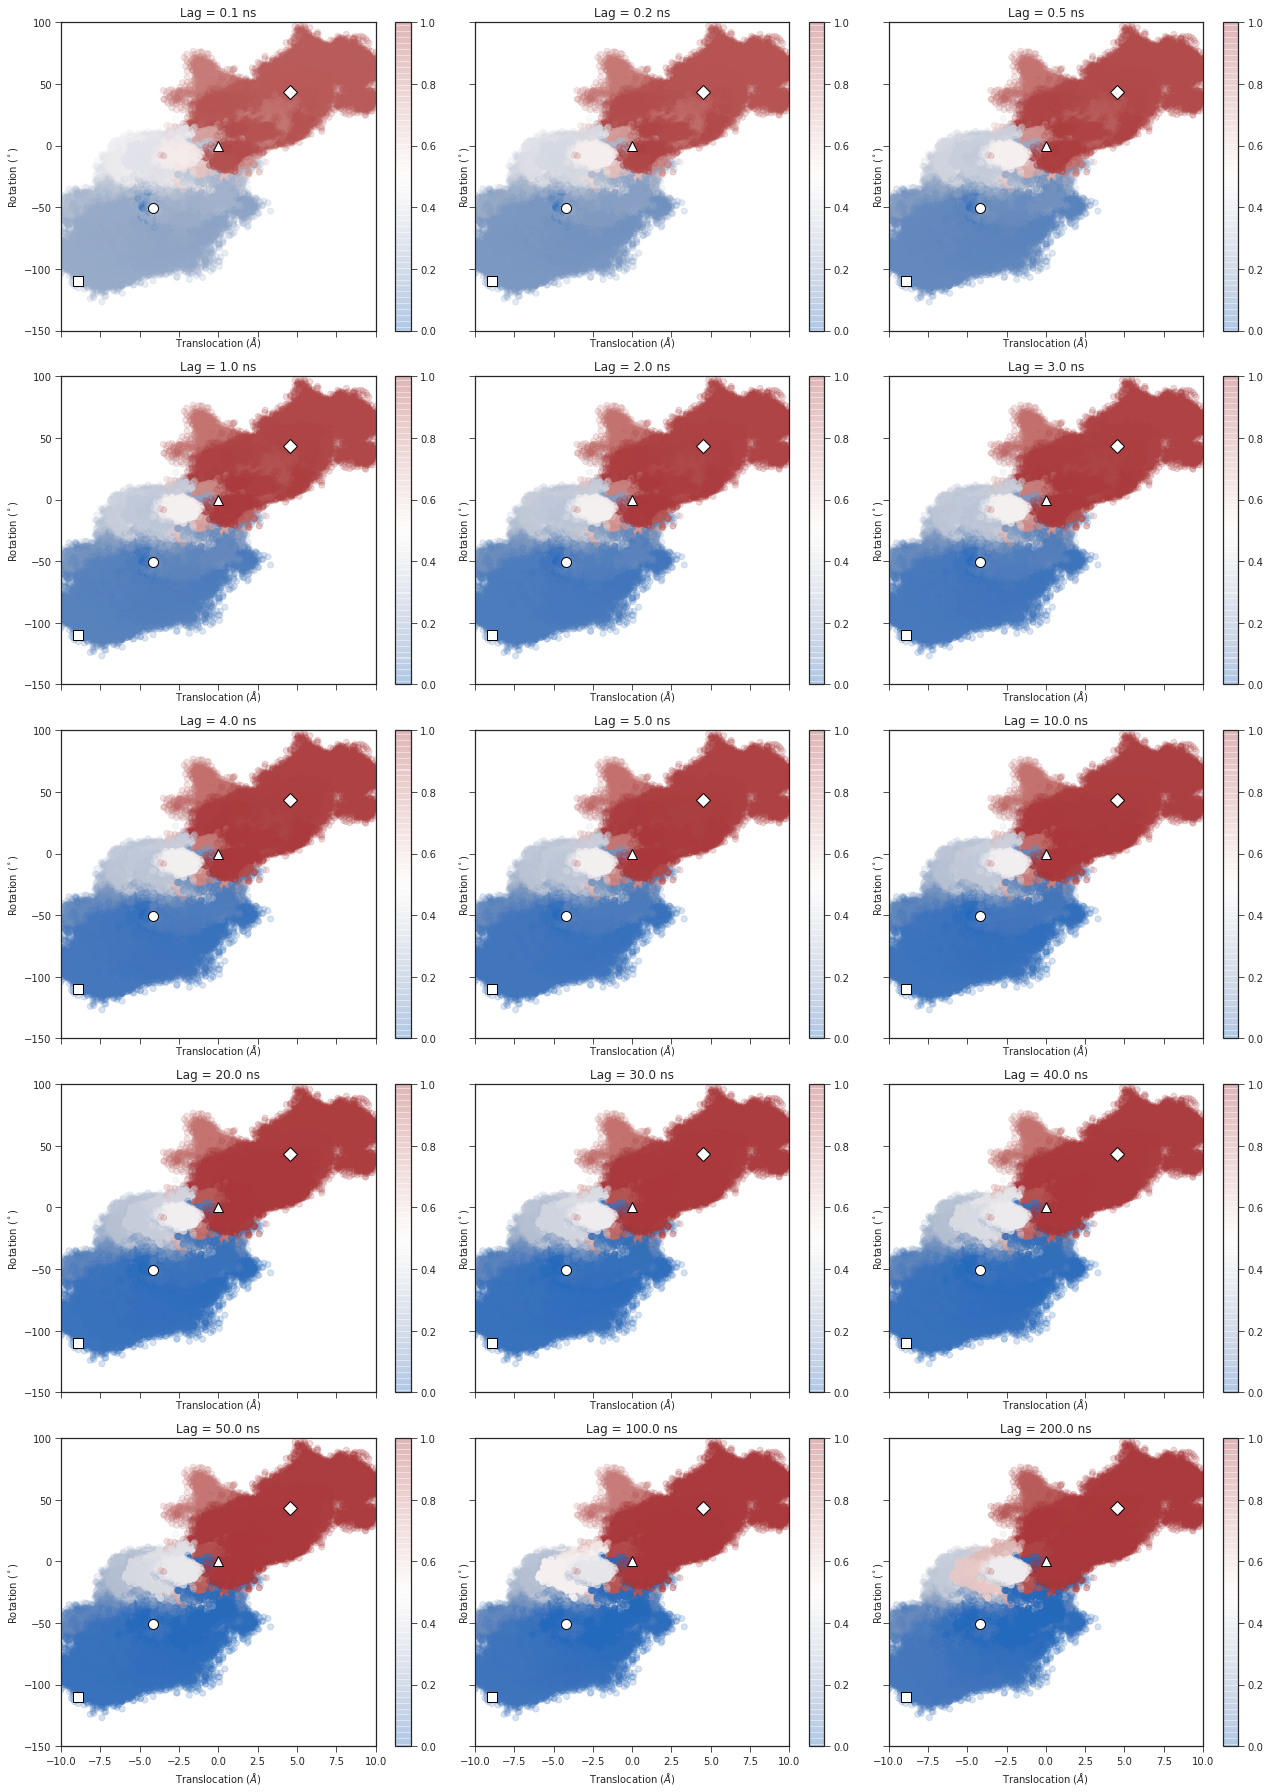

In [116]:
f, axs = plt.subplots(5, 3, figsize=(18, 25), sharex=True, sharey=True)
for lag, q, ax in zip(lags, q_downup, axs.flatten()):
    q_arr = np.concatenate(q)
    h = ax.scatter(
        cv_arr[::10, 0], cv_arr[::10, 1], c=q_arr[::10], cmap="vlag", alpha=0.2
    )
    plt.colorbar(h, ax=ax)
    ax.set_title(f"Lag = {lag * 0.1} ns")
    util.format_cvs(ax)

f.tight_layout()
plt.savefig("../../fig/committors/qf_du_feat1ind200_activation_alllags_ds")

In [58]:
feat2_models = np.load("../../data/models_feat2.npy")

In [59]:
feat2_models.shape

(4, 60)

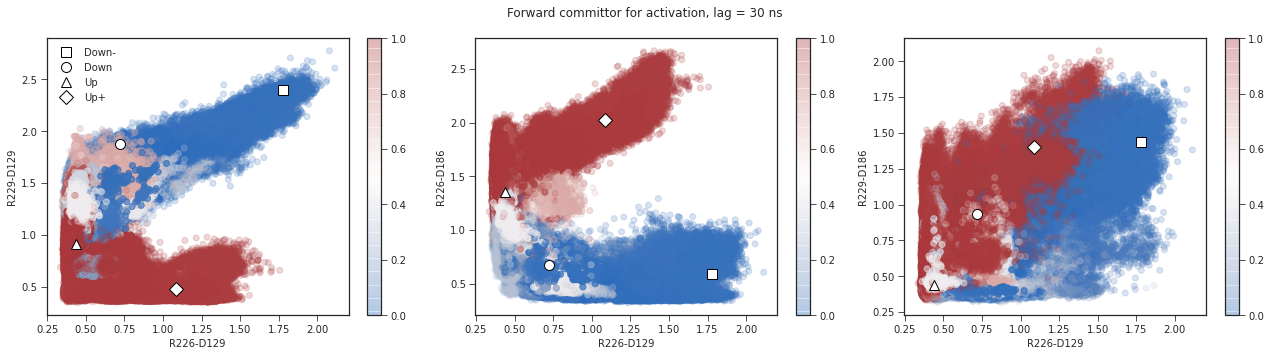

In [117]:
# projection on salt bridges
# R2-D129 vs R3-D129, R2-D186, R3-D186
f, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True)
q = np.concatenate(q_downup[10])
for i, ax in enumerate(axs):
    h = ax.scatter(
        cv_arr[::10, 3], cv_arr[::10, i + 4], c=q[::10], cmap="vlag", alpha=0.2
    )
    plt.colorbar(h, ax=ax)
    ax.set(xlabel=names[3], ylabel=names[i + 4])
util.plot_models(axs[0], feat2_models[:, 42:49:6])  # indexes 42 and 48
util.plot_models(axs[1], feat2_models[:, 42:48:5])  # 42 and 47
util.plot_models(axs[2], feat2_models[:, 42:54:11])  # 42 and 53
axs[0].legend(["Down-", "Down", "Up", "Up+"])
f.suptitle("Forward committor for activation, lag = 30 ns")
f.tight_layout()
plt.savefig("../../fig/committors/qf_du_feat1ind200_activation_lag50_r2d129")

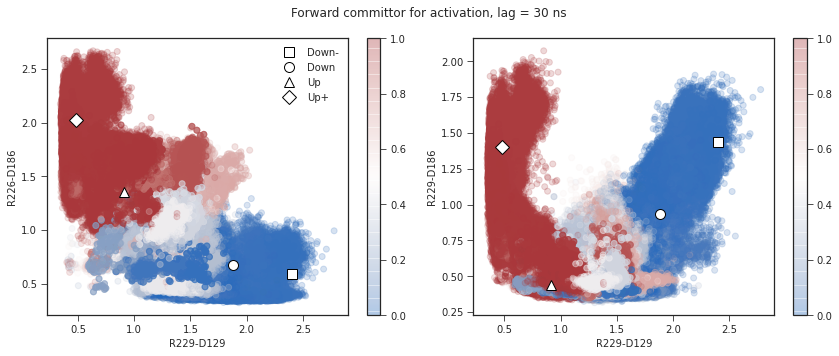

In [118]:
f, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
q = np.concatenate(q_downup[10])
for i, ax in enumerate(axs):
    h = ax.scatter(
        cv_arr[::10, 4], cv_arr[::10, i + 5], c=q[::10], cmap="vlag", alpha=0.2
    )
    plt.colorbar(h, ax=ax)
    ax.set(xlabel=names[4], ylabel=names[i + 5])
util.plot_models(axs[0], feat2_models[:, 48:46:-1])  # indexes 48 and 47
util.plot_models(axs[1], feat2_models[:, 48:54:5])  # 48 and 53
axs[0].legend(["Down-", "Down", "Up", "Up+"])
f.suptitle("Forward committor for activation, lag = 30 ns")
f.tight_layout()
plt.savefig("../../fig/committors/qf_du_feat1ind200_activation_lag50_r3d129")

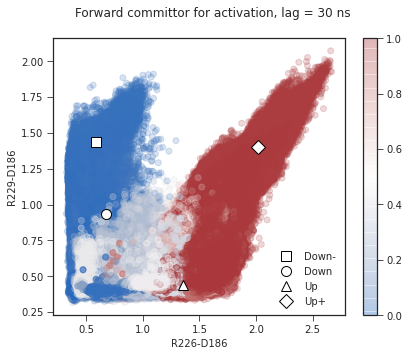

In [67]:
f, ax = plt.subplots(figsize=(6, 5))
q = np.concatenate(q_downup[10])
h = ax.scatter(cv_arr[::10, 5], cv_arr[::10, 6], c=q[::10], cmap="vlag", alpha=0.2)
plt.colorbar(h, ax=ax)
ax.set(xlabel=names[5], ylabel=names[6])
util.plot_models(ax, feat2_models[:, 47:54:6])  # 47 and 53
ax.legend(["Down-", "Down", "Up", "Up+"])
f.suptitle("Forward committor for activation, lag = 30 ns")
f.tight_layout()

In [53]:
%matplotlib inline

In [55]:
from mpl_toolkits.mplot3d import Axes3D

Text(0.5, 0, 'R226-D186')

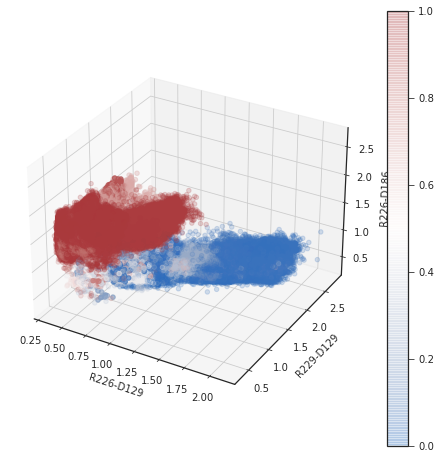

In [56]:
f = plt.figure(figsize=(8, 8))
ax = f.add_subplot(projection="3d")
q = np.concatenate(q_downup[10])
# projection on R226-D129 distance, R229-D129 distance, and R226-D186 distance
h = ax.scatter(*cv_arr[::10, 3:6].T, c=q[::10], cmap="vlag", alpha=0.2)
cbar = plt.colorbar(h, ax=ax)
ax.set(xlabel=names[3], ylabel=names[4])
ax.set_zlabel(names[5])

# Feat3 indicator basis

In [68]:
feat3_trajs = np.load("../../data/raw_feat/feat3_ivac_ind200.npy")

In [69]:
feat3_trajs.shape

(6580000,)

## Basis 

In [71]:
# indicator basis
basisF_arr_feat3 = np.zeros((len(cv_arr), 200))
for i in range(200):
    basisF_arr_feat3[feat3_trajs == i, i] = 1

# enforce boundary conditions
basisF_arr_feat3[down_ids] = 0
basisF_arr_feat3[up_ids] = 0

In [72]:
assert basisF_arr_feat3[down_ids].all() == 0
assert basisF_arr_feat3[up_ids].all() == 0

In [ ]:
# remove bases which are completely 0 (i.e. entirely contained in A U B)
nonzero = np.where(np.sum(basisF_arr_feat3, axis=0) > 0)[0]

basisF_arr_feat3 = basisF_arr_feat3[:, nonzero]

In [ ]:
basisF_arr_feat3.shape

In [31]:
basisF_feat3 = np.split(basisF_arr, traj_inds)

# Committors 

In [119]:
q_downup = np.load("../../data/feat3_ind200_du/q_du_feat3.npy", allow_pickle=True)

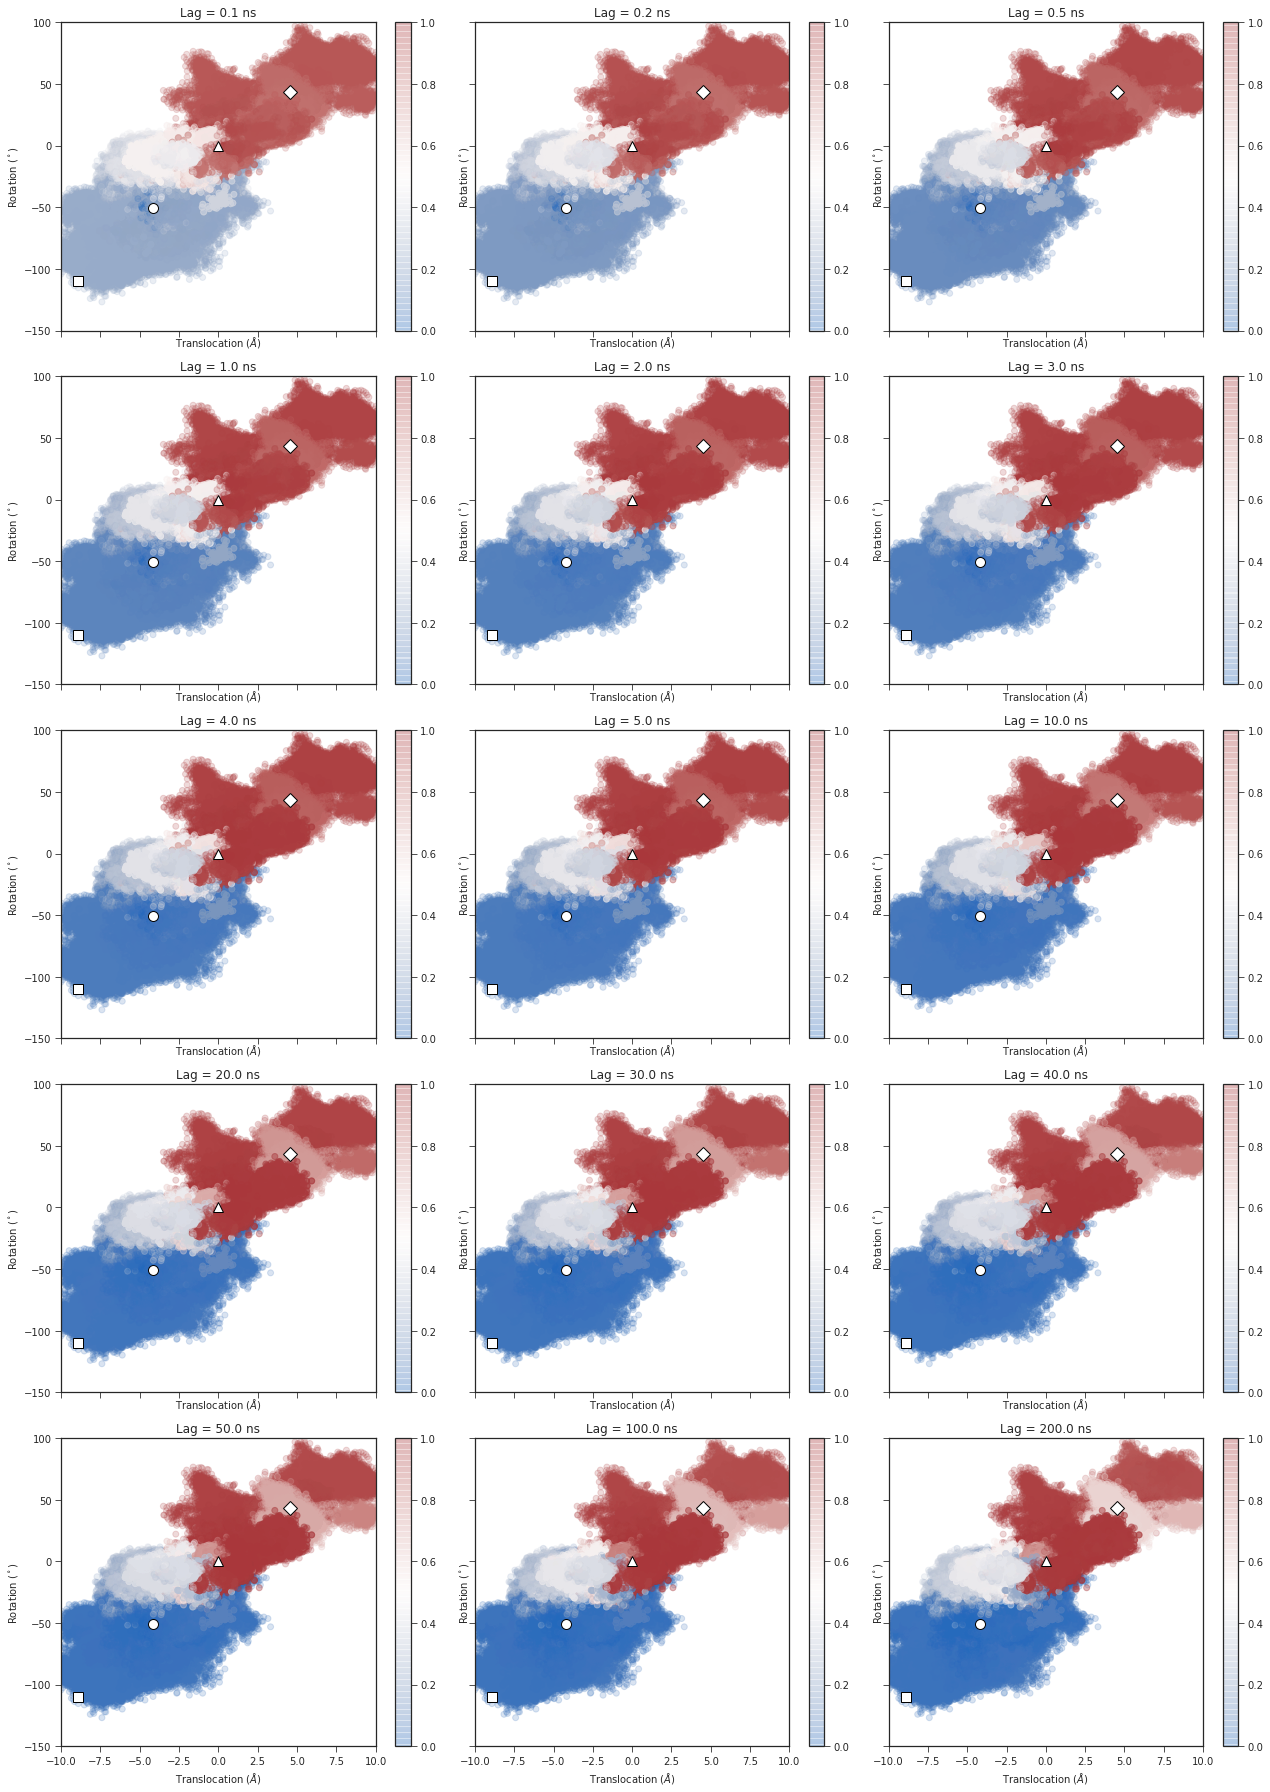

In [120]:
f, axs = plt.subplots(5, 3, figsize=(18, 25), sharex=True, sharey=True)
for lag, q, ax in zip(lags, q_downup, axs.flatten()):
    q_arr = np.concatenate(q)
    h = ax.scatter(
        cv_arr[::10, 0], cv_arr[::10, 1], c=q_arr[::10], cmap="vlag", alpha=0.2
    )
    plt.colorbar(h, ax=ax)
    ax.set_title(f"Lag = {lag * 0.1} ns")
    util.format_cvs(ax)

f.tight_layout()
plt.savefig("../../fig/committors/qf_du_feat3ind200_activation_alllags_ds")

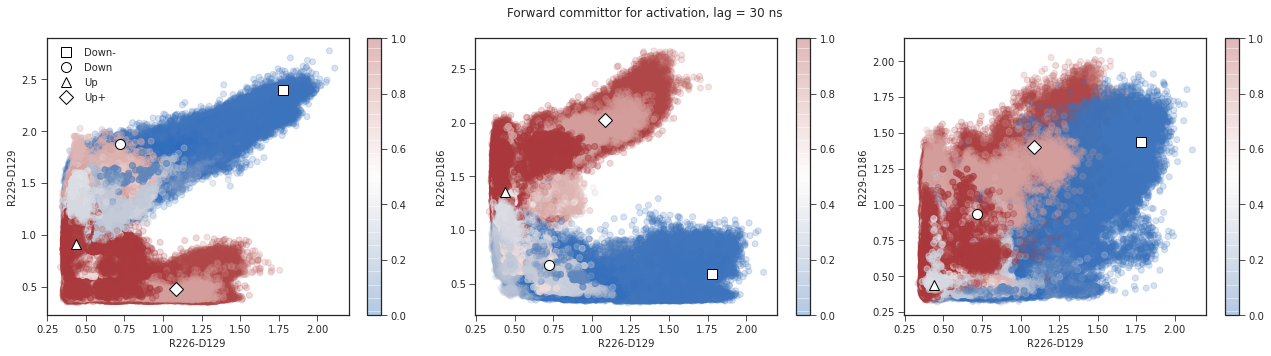

In [121]:
# projection on salt bridges
# R2-D129 vs R3-D129, R2-D186, R3-D186
f, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True)
q = np.concatenate(q_downup[10])
for i, ax in enumerate(axs):
    h = ax.scatter(
        cv_arr[::10, 3], cv_arr[::10, i + 4], c=q[::10], cmap="vlag", alpha=0.2
    )
    plt.colorbar(h, ax=ax)
    ax.set(xlabel=names[3], ylabel=names[i + 4])
util.plot_models(axs[0], feat2_models[:, 42:49:6])  # indexes 42 and 48
util.plot_models(axs[1], feat2_models[:, 42:48:5])  # 42 and 47
util.plot_models(axs[2], feat2_models[:, 42:54:11])  # 42 and 53
axs[0].legend(["Down-", "Down", "Up", "Up+"])
f.suptitle("Forward committor for activation, lag = 30 ns")
f.tight_layout()
plt.savefig("../../fig/committors/qf_du_feat3ind200_activation_lag300_r2d129")

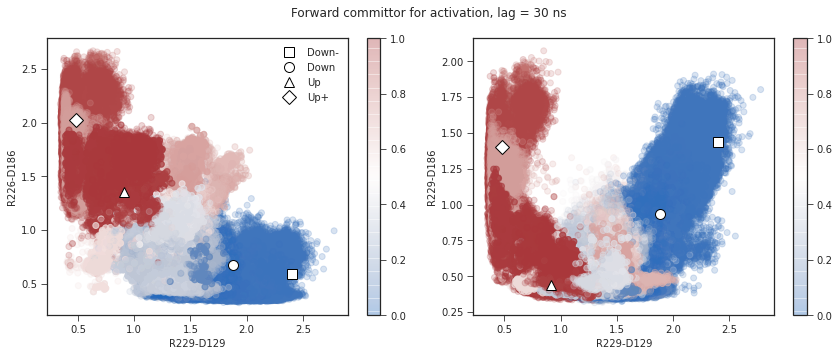

In [122]:
f, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
q = np.concatenate(q_downup[10])
for i, ax in enumerate(axs):
    h = ax.scatter(
        cv_arr[::10, 4], cv_arr[::10, i + 5], c=q[::10], cmap="vlag", alpha=0.2
    )
    plt.colorbar(h, ax=ax)
    ax.set(xlabel=names[4], ylabel=names[i + 5])
util.plot_models(axs[0], feat2_models[:, 48:46:-1])  # indexes 48 and 47
util.plot_models(axs[1], feat2_models[:, 48:54:5])  # 48 and 53
axs[0].legend(["Down-", "Down", "Up", "Up+"])
f.suptitle("Forward committor for activation, lag = 30 ns")
f.tight_layout()
plt.savefig("../../fig/committors/qf_du_feat3ind200_activation_lag300_r3d129")

# Feature 5 indicators 

In [123]:
q_downup = np.load("../../data/feat5_ind200_du/q_du_feat5.npy", allow_pickle=True)

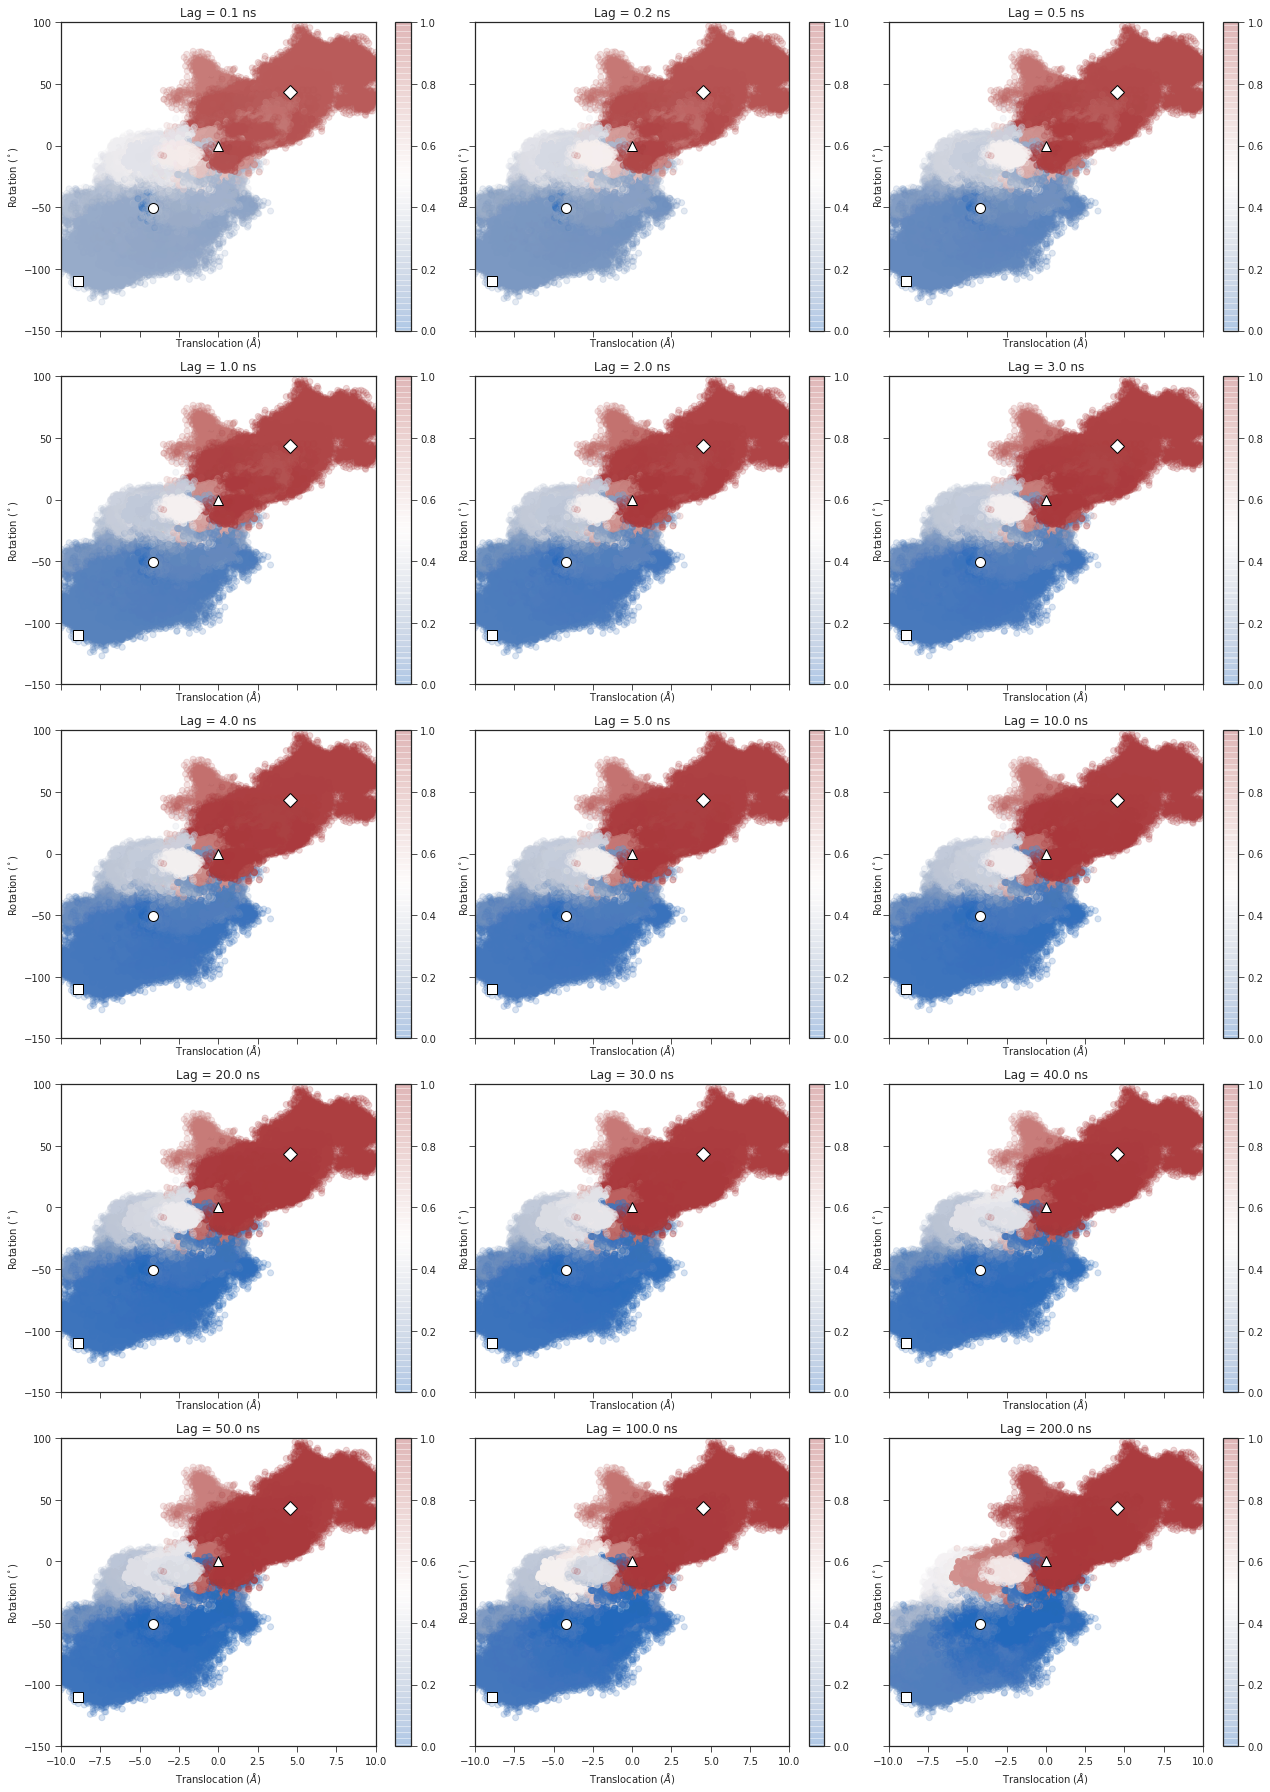

In [124]:
f, axs = plt.subplots(5, 3, figsize=(18, 25), sharex=True, sharey=True)
for lag, q, ax in zip(lags, q_downup, axs.flatten()):
    q_arr = np.concatenate(q)
    h = ax.scatter(
        cv_arr[::10, 0], cv_arr[::10, 1], c=q_arr[::10], cmap="vlag", alpha=0.2
    )
    plt.colorbar(h, ax=ax)
    ax.set_title(f"Lag = {lag * 0.1} ns")
    util.format_cvs(ax)

f.tight_layout()
plt.savefig("../../fig/committors/qf_du_feat5ind200_activation_alllags_ds")

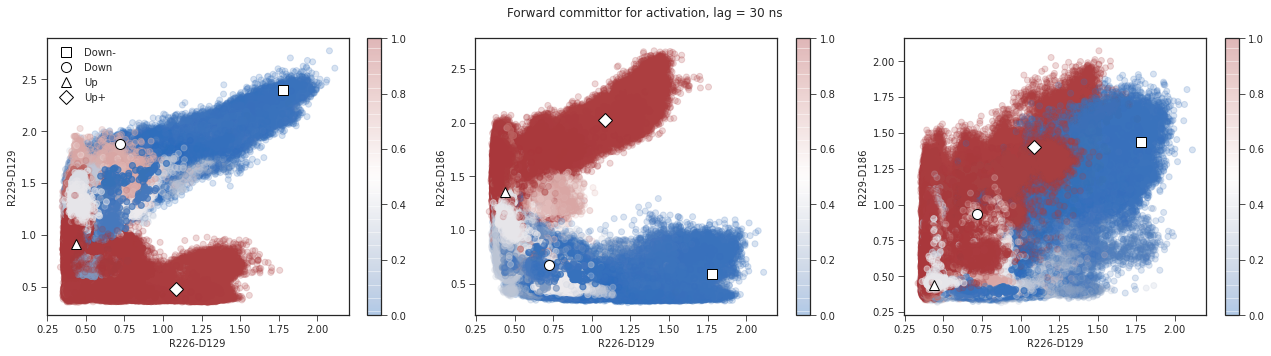

In [125]:
# projection on salt bridges
# R2-D129 vs R3-D129, R2-D186, R3-D186
f, axs = plt.subplots(1, 3, figsize=(18, 5), sharex=True)
q = np.concatenate(q_downup[10])
for i, ax in enumerate(axs):
    h = ax.scatter(
        cv_arr[::10, 3], cv_arr[::10, i + 4], c=q[::10], cmap="vlag", alpha=0.2
    )
    plt.colorbar(h, ax=ax)
    ax.set(xlabel=names[3], ylabel=names[i + 4])
util.plot_models(axs[0], feat2_models[:, 42:49:6])  # indexes 42 and 48
util.plot_models(axs[1], feat2_models[:, 42:48:5])  # 42 and 47
util.plot_models(axs[2], feat2_models[:, 42:54:11])  # 42 and 53
axs[0].legend(["Down-", "Down", "Up", "Up+"])
f.suptitle("Forward committor for activation, lag = 30 ns")
f.tight_layout()
plt.savefig("../../fig/committors/qf_du_feat5ind200_activation_lag300_r2d129")

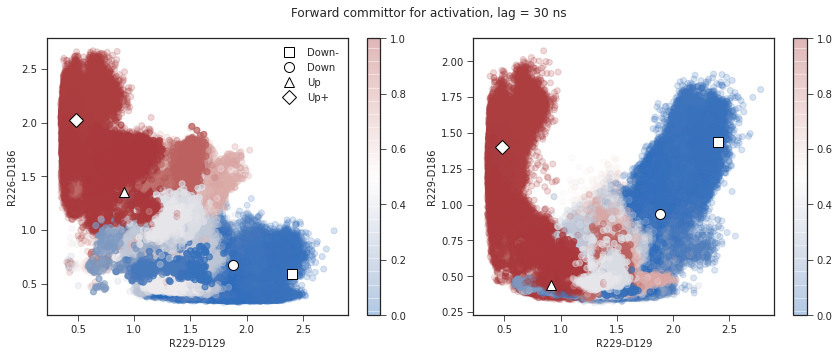

In [126]:
f, axs = plt.subplots(1, 2, figsize=(12, 5), sharex=True)
q = np.concatenate(q_downup[10])
for i, ax in enumerate(axs):
    h = ax.scatter(
        cv_arr[::10, 4], cv_arr[::10, i + 5], c=q[::10], cmap="vlag", alpha=0.2
    )
    plt.colorbar(h, ax=ax)
    ax.set(xlabel=names[4], ylabel=names[i + 5])
util.plot_models(axs[0], feat2_models[:, 48:46:-1])  # indexes 48 and 47
util.plot_models(axs[1], feat2_models[:, 48:54:5])  # 48 and 53
axs[0].legend(["Down-", "Down", "Up", "Up+"])
f.suptitle("Forward committor for activation, lag = 30 ns")
f.tight_layout()
plt.savefig("../../fig/committors/qf_du_feat5ind200_activation_lag300_r3d129")